<a href="https://colab.research.google.com/github/AthithyaJB/AthithyaJB/blob/main/Week03_Lab_NNDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# When running on Colab, get access to Google Drive to read the d2l utility file
try:
    from google.colab import drive
    drive.mount('/gdrive', force_remount=True)
    import sys
    sys.path.append('/gdrive/MyDrive/Colab Notebooks')
except:
    pass

Mounted at /gdrive


In [2]:
%matplotlib inline
import d2l
import torch
import torch.nn as nn
from torch.utils import data

# The Task

* Our **Task** for this week is to apply Linear Regression to Sequential Data; in particular to time series. The model that we will develop is a simple *Auto-Regressive* Model which is an widely-used family of models in Machine Learning. 
* The Learning Outcome: Hands-on application of PyTorch's API for solving Linear Regression.


# Data Generation

* We generate our sequence data by using a function $x = f(t)$ for time steps $1, 2, \ldots, 1000$.
* We define the function $f(.)$ as follows:

In [3]:
def f(time):
    return torch.sin(0.1 * time) * torch.exp(-0.001*time) #+ torch.normal(0, 0.2, (T,))

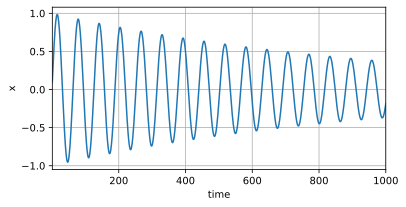

In [4]:
# Run the following code
T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = f(time)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

## Question
* Do you expect that a linear model can approximately well the above function?

## Task 1
* Your first task is to turn the above sequence into features and labels that we can train our model on.
* You should create your dataset as follows: for every time instance $t$, the target (i.e. ground truth label) will be $y_t = x_t$ and the input features $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$. 
    * Choose $\tau=4$ and start from $t=\tau+1$. So the first (input features, target) pair should be $([x_0, x_1, x_2, x_3], x_4)$, the second $([x_1, x_2, x_3, x_4], x_5)$ and so on.
* Store the features in a matrix (using a tensor from `torch`) called `features` so that the first row contains the first input feature, the second row the second input feature and so on. For example `features[0, :]= x_0, x_1, x_2, x_3`.
*  Store the labels in a vector (using a tensor from `torch`) called `labels` so that the first element contains the first target, the second row the second label and so on.  


In [15]:
# Write your code here to create the two tensors: features and labels
tau =4 
features =torch.empty((T - tau, tau))
# Fill by row
for i in range(T-tau):
  features[i] = x[i:i+tau]
labels = x[tau:].reshape(-1,1)  

In [22]:
#or fill by column
featuress =torch.empty((T - tau, tau))
for i in range(tau):
  featuress[:,i] = x[i: T - tau + i]

In [25]:
features

tensor([[ 0.0997,  0.1983,  0.2946,  0.3879],
        [ 0.1983,  0.2946,  0.3879,  0.4770],
        [ 0.2946,  0.3879,  0.4770,  0.5613],
        ...,
        [-0.3349, -0.3171, -0.2963, -0.2725],
        [-0.3171, -0.2963, -0.2725, -0.2461],
        [-0.2963, -0.2725, -0.2461, -0.2172]])

In [24]:
labels

tensor([[ 4.7703e-01],
        [ 5.6126e-01],
        [ 6.3972e-01],
        [ 7.1164e-01],
        [ 7.7631e-01],
        [ 8.3310e-01],
        [ 8.8146e-01],
        [ 9.2092e-01],
        [ 9.5111e-01],
        [ 9.7175e-01],
        [ 9.8264e-01],
        [ 9.8371e-01],
        [ 9.7495e-01],
        [ 9.5648e-01],
        [ 9.2849e-01],
        [ 8.9129e-01],
        [ 8.4527e-01],
        [ 7.9090e-01],
        [ 7.2875e-01],
        [ 6.5944e-01],
        [ 5.8370e-01],
        [ 5.0227e-01],
        [ 4.1599e-01],
        [ 3.2574e-01],
        [ 2.3241e-01],
        [ 1.3695e-01],
        [ 4.0311e-02],
        [-5.6536e-02],
        [-1.5262e-01],
        [-2.4700e-01],
        [-3.3872e-01],
        [-4.2687e-01],
        [-5.1059e-01],
        [-5.8904e-01],
        [-6.6146e-01],
        [-7.2713e-01],
        [-7.8541e-01],
        [-8.3573e-01],
        [-8.7761e-01],
        [-9.1064e-01],
        [-9.3452e-01],
        [-9.4902e-01],
        [-9.5401e-01],
        [-9

In [26]:
# Might be good idea to check here that the features and labels tensors contain the right data  
# What are their dimensions? Make sure that features.size() gives you a matrix of size 994x4 and labels.size() 
# a vector of size 994x1
print(features.shape)
print(labels.shape)
print(x[:7])
print(features[0:3])
print(labels[0:3])

torch.Size([996, 4])
torch.Size([996, 1])
tensor([0.0997, 0.1983, 0.2946, 0.3879, 0.4770, 0.5613, 0.6397])
tensor([[0.0997, 0.1983, 0.2946, 0.3879],
        [0.1983, 0.2946, 0.3879, 0.4770],
        [0.2946, 0.3879, 0.4770, 0.5613]])
tensor([[0.4770],
        [0.5613],
        [0.6397]])


# Task 2
* Use `data.TensorDataset` and the previously created matrices to create your dataset. Simply call it `dataset`. 
    * Use the first `n_train=600` feature-label pairs for training.
    * Check lecture slides and `torch` documentation if necessary.
* Use `data.DataLoader` to create your dataloader. Pick a reasonable value for the batch size (e.g. `batch_size=16`).
    * You can call your dataloader `data_iter`.

In [31]:
# Write your code here to create dataset and data_iter
n_train = 600 # number of feature-labels pairs used for training
dataset = data.TensorDataset(features[0:n_train], labels[0:n_train])
batch_size = 16
data_iter = data.DataLoader(dataset, batch_size, shuffle=True)
print (dataset)

# Task 3
* This task is about creating, initializing and training a linear net, using PyTorch's API. You have to implement the following 4 steps: 
    1. Create a simple linear net and initialize it appropriately.
    1. Use an MSE loss.
    1. From `torch.optim` use SGD to create an `optimizer` with a learning rate equal to 0.01.
    1. Write a training function with the following signature `train(net, data_iter, loss, optimizer, epochs)` and use it to train your network.

In [ ]:
# Write code for defining and initializing your model here

In [42]:
num_of_inp, num_of_out = 4, 1 # input, output feature dimension 
net = nn.Linear(num_of_inp, num_of_out)

In [ ]:
# Write code for creating the loss and the optimizer here

In [43]:
loss = nn.MSELoss()
def squared_loss(y_hat, y):
  """Squared loss."""
  return (y_hat - y.reshape(y_hat.size())) ** 2 / 2

In [ ]:
# Write code for the training function train(net, data_iter, loss, optimizer, epochs) here

In [44]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
num_epochs = 100

In [ ]:
# Write code for training the model here. This refers to calling the train function. 

In [45]:
for epoch in range(num_epochs):
  for X, y in data_iter:
    y_hat = net(X)
    #print(y.size(), y_hat.size())
    l = loss(y_hat, y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
  l = loss(net(features), labels)
  print(f'epoch {epoch + 1}, loss {l:f}')


epoch 1, loss 0.081730
epoch 2, loss 0.028671
epoch 3, loss 0.018972
epoch 4, loss 0.016850
epoch 5, loss 0.016176
epoch 6, loss 0.015766
epoch 7, loss 0.015417
epoch 8, loss 0.015085
epoch 9, loss 0.014760
epoch 10, loss 0.014443
epoch 11, loss 0.014134
epoch 12, loss 0.013826
epoch 13, loss 0.013527
epoch 14, loss 0.013235
epoch 15, loss 0.012947
epoch 16, loss 0.012667
epoch 17, loss 0.012393
epoch 18, loss 0.012127
epoch 19, loss 0.011865
epoch 20, loss 0.011608
epoch 21, loss 0.011356
epoch 22, loss 0.011110
epoch 23, loss 0.010871
epoch 24, loss 0.010638
epoch 25, loss 0.010410
epoch 26, loss 0.010183
epoch 27, loss 0.009960
epoch 28, loss 0.009745
epoch 29, loss 0.009532
epoch 30, loss 0.009327
epoch 31, loss 0.009125
epoch 32, loss 0.008929
epoch 33, loss 0.008735
epoch 34, loss 0.008546
epoch 35, loss 0.008368
epoch 36, loss 0.008181
epoch 37, loss 0.008004
epoch 38, loss 0.007831
epoch 39, loss 0.007660
epoch 40, loss 0.007497
epoch 41, loss 0.007334
epoch 42, loss 0.007175
e

## Task 4 

* Use the model to *predict* what happens in the next time step. 
    * This is called *one-step-ahead prediction*.
    * Store the output of your model in variable called `onestep_preds` and use the following code to plot the original data and the model's prediction.
    * What do you observe? Can the model predict the output samples correctly? Can you explain why?

In [ ]:
# Write code for getting the model's predictions onestep_preds here

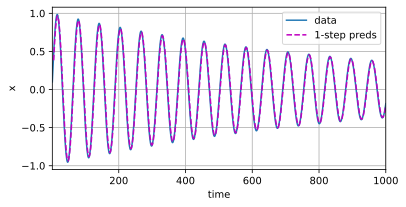

In [47]:
# this will not work if the you don't provide onestep_preds :)
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [d2l.numpy(x), d2l.numpy(onestep_preds)], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

## Task 5
* Modify the above code to plot the absolute difference between the data and the model's prediction.

In [ ]:
# Write the modified plot function here

## Task 6

* Change the generating function to $x = \frac{1.0}{1.0 + f(t)}$ and repeat the above mentioned steps.
* What do you observe? 


## Task 7 -- Optional

* Re-run your code with the original generating function to $x = f(t)$.
* It turns out that our previous predictions were too good to be true. The reason for this is that after we train the model using the first let's say 600 samples we cannot expect to have the inputs for all one-step-ahead predictions beyond this point.

* Instead, we need to work our way forward one step at a time:

$$
\hat{x}_{600} = f(x_{596}, x_{597}, x_{598}, x_{599}), \\
\hat{x}_{601} = f(x_{597}, x_{598}, x_{599}, \hat{x}_{600}), \\
\hat{x}_{602} = f(x_{598}, x_{599}, \hat{x}_{600}, \hat{x}_{601}),\\
\hat{x}_{603} = f(x_{599}, \hat{x}_{600}, \hat{x}_{601}, \hat{x}_{602}),\\
\hat{x}_{604} = f(\hat{x}_{600}, \hat{x}_{601}, \hat{x}_{602}, \hat{x}_{603}),\\
\ldots
$$

* In other words, we will have to use our own predictions to make multistep-ahead predictions.
* You are tasked to write some code to do this. Store the model's prediction in a variable called `multistep_preds`.

In [ ]:
# Write the code to obtain the multistep-ahead predictions (multistep_preds) here

## Task 8 -- Optional
* Modify the plotting code above to plot the original data, the one step predictions from Task 4 (`onestep_preds`) along with the multistep-ahead predictions from Task 7.
* What do you observe? Do you have some explanation for what happens?